# Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

random.seed(45)

# Train Test Split

In [2]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size*len(df))#Calculating the test size 

    indices = df.index.tolist()
    test_indices = random.sample(population = indices, k = test_size)#Random sampling of data

    test_df = df.loc[test_indices]#Getting the test data set
    train_df = df.drop(test_indices)#Getting the train data set
    return train_df, test_df

### Data Pure?

In [3]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if(len(unique_classes)) == 1:#Only 1 target attribute present in data
        return True
    else:
        return False

### Classify Data

In [4]:
def classify_data(data):
    
    label_column = data[:, -1]
    
    classification = np.mean(label_column)#Final classification of data as mean of all target attriutes present 
   
    return classification

### Potential Splits

In [5]:
def get_potential_splits(data):#Getting all the potential points with which we can split data
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        for index in range(len(unique_values)):
            if index!=0:
                current_value = unique_values[index]
                previous_value = unique_values[index-1]
                potential_split = (current_value+previous_value)/2
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

###   Split Data

In [6]:
def split_data(data, split_column, split_value):#Splitting data with the target attribute specified and target attribute vale
    
    split_column_values = data[:, split_column]
    
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >= split_value]
    
    return data_below, data_above


### Determine Best Split

In [7]:
def calculate_mse(data):#Returns the mean squared error of the target attribute in dataset passed
    
    actual_values = data[:, -1]
    
    if len(actual_values) == 0: 
        mean_squared_error = 0
    else :
        prediction = np.mean(actual_values)
        mean_squared_error = np.mean((actual_values - prediction)**2)
    return mean_squared_error

In [8]:
def calculate_overall_mse(data_below, data_above):#Calculate overall mse of the data_above and data_below
    n_data_points = len(data_below) + len(data_above)
    
    p_data_below = len(data_below)/n_data_points
    p_data_above = len(data_above)/n_data_points
    
    overall_mse = (p_data_below*calculate_mse(data_below)
                      +p_data_above*calculate_mse(data_above))#Weighted average of mse of the 2 parts
    
    return overall_mse

In [9]:
def determine_best_split(data, potential_splits, counter):
    overall_mse = -1#Finding the best split that provides best reduction in overall mean squared error
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column = column_index, split_value = value)
            current_overall_mse = calculate_overall_mse(data_below, data_above)
            if overall_mse < 0:
                overall_mse = current_overall_mse
                best_split_column = column_index
                best_split_value = value
            elif counter%2 == 0 and (current_overall_mse < overall_mse):
                overall_mse = current_overall_mse
                best_split_column = column_index
                best_split_value = value
            elif counter%2 == 1 and (current_overall_mse <= overall_mse):
                overall_mse = current_overall_mse
                best_split_column = column_index
                best_split_value = value
    if best_split_value == 0:
        print(data)
    return best_split_column, best_split_value#This is the best split returned

### Decision Tree Algorithm

#### Algorithm

In [10]:
def decision_tree_algorithm(dataf, counter=0, max_depth = 10):
    
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataf.columns
        data = dataf.values
    else:
        data = dataf
    
    #base case
    #print(data)
    if check_purity(data):
        #print(True)
        classification = classify_data(data)
        return classification
    elif counter >= max_depth and max_depth>0:
        classification = classify_data(data)
        return classification
    #recursive part
    else:
        counter+=1
        
        #helper functions
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, counter)
        data_below, data_above = split_data(data, split_column,split_value)
        
        #print("split_column {}, split_value {}".format(split_column, split_value))
        if len(data_below)==0 or len(data_above)==0:
            classification = classify_data(data)
            return classification
        #instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        #find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, max_depth)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

# Prediction

In [11]:
def classify_example(example, tree):#Predicting final value of unseen example with given tree
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()
    #print(example[feature_name])
    if example[feature_name] <= float(value):
        answer = tree[question][0]
        #print(answer)
    else:
        answer = tree[question][1]
        #print(answer)
    #base case
    if not isinstance(answer, dict):
        return float(answer)
    #Recursive Call
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

# Hyperparameter Tuning

In [12]:
def calculate_r_squared(df, tree):#Measure of accuracy 
    labels = df.label
    mean = labels.mean()
    predictions = df.apply(classify_example, args=(tree,), axis = 1)
    
    ss_res = sum((labels-predictions)**2)
    ss_tot = sum((labels-mean)**2)
    r_squared = 1 - ss_res/ss_tot
    
    return r_squared

# Running Method

In [13]:
def build_tree():
    df = pd.read_csv("PercentageIncreaseCOVIDWorldwide.csv")
    df = df.drop("Date", axis = 1)
    df = df.rename(columns = {"Increase rate": "label"})
    df = df.drop(df.index[0])
    print("Enter Maximum Depth")
    max = input()
    r_squared = 0.00
    for i in range(10):#Finding the best split over 10 random 80:20 splits 
        train_val_df, test_df = train_test_split(df, test_size = 0.2)
        train_df, val_df = train_test_split(train_val_df, test_size = 0.25)
        tree = decision_tree_algorithm(train_df, counter = 0, max_depth = int(max))
        r_squared_train = calculate_r_squared(train_df, tree)
        r_squared_test = calculate_r_squared(test_df, tree)
        if r_squared_test > r_squared:#Finding the split offering best test accuracy
            r_squared = r_squared_test
            train_df_best = train_df
            test_df_best = test_df
            val_df_best = val_df
            
    return train_df_best, test_df_best, val_df_best

In [14]:
train_df_best, test_df_best, val_df_best = build_tree()

Enter Maximum Depth
6


In [15]:
grid_search = {"max_depth": [],  "r_squared_train": [], "r_squared_test": []}

for max_depth in range (1,11):#Recording train and test error over different max depths
    tree = decision_tree_algorithm(train_df_best, counter = 0, max_depth = max_depth)
    r_squared_train = calculate_r_squared(train_df_best, tree)
    r_squared_test = calculate_r_squared(test_df_best, tree)
    r_squared_val = calculate_r_squared(val_df_best, tree)    
    
    grid_search["max_depth"].append(max_depth)
    grid_search["r_squared_train"].append(r_squared_train)
    grid_search["r_squared_test"].append(r_squared_test)
    
    print("Progress: Iteration {}/10".format(max_depth))
    
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_test", ascending = False)

Progress: Iteration 1/10
Progress: Iteration 2/10
Progress: Iteration 3/10
Progress: Iteration 4/10
Progress: Iteration 5/10
Progress: Iteration 6/10
Progress: Iteration 7/10
Progress: Iteration 8/10
Progress: Iteration 9/10
Progress: Iteration 10/10


,max_depth,r_squared_train,r_squared_test
6,7,0.998859,0.778993
5,6,0.997140,0.778417
7,8,0.999582,0.778260
8,9,0.999785,0.778253
9,10,0.999922,0.777870
3,4,0.975295,0.748259
4,5,0.986054,0.740042
2,3,0.907342,0.648440
1,2,0.855019,0.629770
0,1,0.609444,0.459665


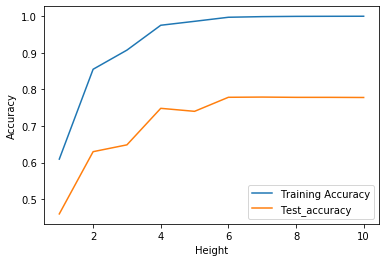

In [16]:
plt.plot(grid_search["max_depth"], grid_search["r_squared_train"], label = 'Training Accuracy')
plt.plot(grid_search["max_depth"], grid_search["r_squared_test"], label = 'Test_accuracy')
plt.xlabel("Height")
plt.ylabel("Accuracy")
plt.legend()

In [17]:
max_accuracy = grid_search["r_squared_test"][0]
best_depth = 1
for i in range(0, len(grid_search["r_squared_test"])):
    if grid_search["r_squared_test"][i] >= max_accuracy:
        max_accuracy = grid_search["r_squared_test"][i]
        best_depth = i+1

print("Best Depth of the tree for which test accuracy is maximum is : {}".format(best_depth))

Best Depth of the tree for which test accuracy is maximum is : 7


In [18]:
tree_best = decision_tree_algorithm(train_df_best, counter = 0, max_depth = best_depth)

# Post Pruning

In [19]:
def post_pruning(tree, df_train, df_val):
    
    question = list(tree.keys())[0]
    #print(question)
    yes_answer, no_answer = tree[question]
    #base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        prediction = df_train.label.mean()
        leaf = prediction
        new_tree = {question : [prediction, prediction]}
        if df_train.shape[0]<=1 or df_val.shape[0] <= 1:
            return tree
        accuracy_leaf = calculate_r_squared(df_val, new_tree)
        accuracy_tree = calculate_r_squared(df_val, tree)
        
        if accuracy_leaf >= accuracy_tree:#if post-pruning accuracy > pre-pruning accuracy
            print("trimmed at node {}".format(question))#To check which nodes are trimmed
            return prediction
        else:
            return tree
    # Recursive part
    else:
        feature, _, value = question.split()
        df_train_yes = df_train[df_train[feature] <= float(value)]
        df_train_no = df_train[df_train[feature] > float(value)]
        df_val_yes = df_val[df_val[feature] <= float(value)]
        df_val_no = df_val[df_val[feature] > float(value)]
        
        if isinstance(yes_answer, dict):#Non leaf
            tree[question][0] = post_pruning(yes_answer, df_train_yes, df_val_yes)
        
        if isinstance(no_answer, dict):#Non leaf
            tree[question][1] = post_pruning(no_answer, df_train_no, df_val_no)
            
        return tree
    
   

In [20]:
tree_best_pruned = post_pruning(tree_best, train_df_best, val_df_best)#Pruning the tree
            

trimmed at node Deaths <= 54.0
trimmed at node Deaths <= 474925.0
trimmed at node Deaths <= 848444.0


In [21]:
class PrintTree:#Printing the tree
    def printTree(self, tree, d = 0):
        if (tree == None or len(tree) == 0):
            print("\t" * d, "-")
        else:
            for key, val in tree.items():
                    print ("\t" * d, key)
                    for j in val:
                        if j==val[0]:
                            print("\t" * d,"(True) ")
                        else: 
                            print("\t" * d,"(False) ")
                        if isinstance(j,dict):
                            self.printTree(j, d+1)
                        else:
                            if j==val[0]:
                                print ("\t" * d, "Predicted Rate =",j)
                            else:
                                print ("\t" * d, "Predicted Rate =",j)

final_tree=PrintTree()
#pprint(tree_best_pruned)
final_tree.printTree(tree_best_pruned)

 Deaths <= 563.0
 (True) 
	 Confirmed <= 4546.5
	 (True) 
	 Predicted Rate = 41.040101879999995
	 (False) 
		 Deaths <= 173.0
		 (True) 
		 Predicted Rate = 10.54141269
		 (False) 
			 Confirmed <= 17968.0
			 (True) 
				 Deaths <= 236.0
				 (True) 
				 Predicted Rate = 20.54894341
				 (False) 
				 Predicted Rate = 21.27745315
			 (False) 
			 Predicted Rate = 20.16895459
 (False) 
	 Confirmed <= 2288578.5
	 (True) 
		 Deaths <= 4299.0
		 (True) 
			 Confirmed <= 67979.0
			 (True) 
				 Deaths <= 762.5
				 (True) 
					 Confirmed <= 32598.5
					 (True) 
					 Predicted Rate = 11.42784792
					 (False) 
					 Predicted Rate = 11.66482696
				 (False) 
					 Confirmed <= 55859.0
					 (True) 
						 Deaths <= 1063.0
						 (True) 
						 Predicted Rate = 7.222752743
						 (False) 
						 Predicted Rate = 4.77459783
					 (False) 
					 Predicted Rate = 10.80969179
			 (False) 
				 Deaths <= 1995.5
				 (True) 
					 Confirmed <= 72251.5
					 (True) 
						 Deaths <= 1718.0
			

In [22]:
r_squared_test = calculate_r_squared(test_df_best, tree_best_pruned)
print("New Test Accuracy: {} ".format(r_squared_test))#Displaying new test accuracy post pruning

New Test Accuracy: 0.7892350142716837 
